## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
from torch import Tensor

from typing import Callable
from typing import Dict

In [2]:
IMAGE_FOLDER = "../images/graphs/01_foundations/"

In [3]:
torch.manual_seed(72818);

### Matrix forward

In [4]:
def matrix_forward(x: Tensor, 
                   w: Tensor) -> Tensor:
    
    assert x.shape[1] == w.shape[0]
    
    # matrix multiplication
    N = x.mm(w)
    
    return N

In [5]:
X = torch.empty(1, 3).uniform_(-1, 1)
W = torch.empty(3, 1).uniform_(-1, 1)
print("X:", X)
print("W:", W)
N = matrix_forward(X, W)
print("N:", N)

X: tensor([[ 0.2226,  0.8752, -0.6804]])
W: tensor([[ 0.3351],
        [ 0.3456],
        [-0.7701]])
N: tensor([[0.9010]])


In [6]:
def matrix_backward_1(x: Tensor, 
                      w: Tensor) -> Tensor:
    '''
    Computes the backward pass of a matrix multiplication with respect to
    the first element.
    '''

    # backward pass
    dNdx = w.transpose(0, 1)
    
    return dNdx

In [7]:
matrix_backward_1(X, W)

tensor([[ 0.3351,  0.3456, -0.7701]])

### Matrix forward with function

In [8]:
def sigmoid(x: Tensor) -> Tensor:
    '''
    Square each element in the input Tensor.
    '''
    return 1 / (1 + torch.exp(-x))

In [9]:
Tensor_Function = Callable[[Tensor], Tensor]

def matrix_function_forward(x: Tensor, 
                            w: Tensor, 
                            sigma: Tensor_Function) -> Tensor:
    
    assert x.shape[1] == w.shape[0]
    
    # matrix multiplication
    N = x.mm(w)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    
    return S

In [10]:
matrix_function_forward(X, W, sigmoid)

tensor([[0.7111]])

### Matrix with function - backward

#### deriv definition

In [11]:
def deriv(func: Callable[[Tensor], Tensor],
          input: Tensor,
          diff: float = 0.001) -> Tensor:
    '''
    Evaluates the derivative of a function f at every element in the Tensor.
    '''
    return (func(input + diff) - func(input - diff)) / (2 * diff)

In [12]:
def matrix_function_backward_1(x: Tensor, 
                               w: Tensor, 
                               sigma: Tensor_Function) -> Tensor:
    '''
    Computes the derivative of this function with respect to 
    the first element.
    '''    
    assert x.shape[1] == w.shape[0]
    
    # matrix multiplication
    N = x.mm(w)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    
    # backward calculation   
    dSdN = deriv(sigma, N)
    
    # dNdX
    dNdX = w.transpose(0, 1)    
    
    # multiply them together; since dNdX is 1x1 here, order doesn't matter
    return dSdN * dNdX

In [13]:
matrix_function_backward_1(X, W, sigmoid)

tensor([[ 0.0688,  0.0710, -0.1582]])

In [14]:
def L(x: Tensor) -> Tensor:
    '''
    Sum every element in the input Tensor.
    '''
    return torch.sum(x)

## Matrix functions

### Adding matrices

In [121]:
def matrix_function_backward_sum(x: Tensor, 
                                   w: Tensor, 
                                   sigma: Tensor_Function) -> Tensor:
    '''
    Computes the derivative of this function with respect to 
    the first element.
    '''    
    assert x.shape[1] == w.shape[0]
    
    # matrix multiplication
    N = x.mm(w)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    
    # sum all the elements
    L = torch.sum(S)
    
    # dLdS
    dLdS = torch.ones_like(S)    
    
    # backward calculation   
    dSdN = deriv(sigma, N)

    # dNdX
    dNdX = w.transpose(0, 1)
    
    # multiply them together; since dNdX is 1x1 here, order doesn't matter
    return dSdN.mm(dNdX)

In [122]:
X = torch.empty(3, 3).uniform_(-1, 1)
W = torch.randn((3,2))

In [123]:
matrix_function_forward_sum(X, W, sigmoid)

tensor(2.4521)

In [124]:
dLdX = matrix_function_backward_sum(X, W, sigmoid)
print(dLdX)

tensor([[ 0.3831,  0.1318, -0.0793],
        [ 0.5423,  0.1549, -0.1411],
        [ 0.5209,  0.1518, -0.1328]])


In [125]:
X

tensor([[-0.1605, -0.8340,  0.9784],
        [-0.5992,  0.8069, -0.8407],
        [-0.5177,  0.4222, -0.5012]])

The claim is that, at the current value of $x_{11}$ - $-0.1605$ - changing this value by 0.01 will change the value of $L$ from $2.4521$ to $2.4521 + 0.01 * 0.3831 = 2.4559$.

In [126]:
2.4521 + 0.01 * 0.3831

2.455931

Let's verify this numerically:

In [127]:
from copy import deepcopy
X2 = deepcopy(X)
X2[0][0] = X2[0][0] + 0.01

In [128]:
matrix_function_forward_sum(X2, W, sigmoid)

tensor(2.4559)

In [129]:
def matrix_function_forward_sum(x: Tensor, 
                                w: Tensor, 
                                sigma: Tensor_Function,
                                modify_x11: bool = False, 
                                x11: float = 0.5) -> float:

    assert x.shape[1] == w.shape[0]

    if modify_x11:
        x[0][0] = x11
    
    # matrix multiplication
    N = x.mm(w)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    
    # sum all the elements
    L = torch.sum(S)
    
    return L

In [141]:
x11s = np.arange(-1, 1, 0.01)
Ls = [matrix_function_forward_sum(X, W, sigmoid, 
                                  modify_x11 = True, 
                                  x11=x11).item() for x11 in x11s]

In [142]:
Ls[0] # -1.00
Ls[1] # -0.99
Ls[2] # -0.98
# ...
Ls[84] # x = -0.16

2.4522786140441895

In [146]:
(Ls[85] - Ls[83]) / (-0.15 - (-0.17))

0.38328170776367154

The value of:

In [132]:
x11s = np.arange(-1, 1, 0.001)
Ls = [matrix_function_forward_sum(X, W, sigmoid, 
                                  modify_x11 = True, 
                                  x11=x11).item() for x11 in x11s]

In [136]:
Ls[0] # -1.000
Ls[1] # -0.999
Ls[2] # -0.998
# ...
Ls[839] # x = -0.161

2.4518954753875732

The value of:

In [144]:
(Ls[840] - Ls[838]) / 0.02

IndexError: list index out of range

Which is very close to the actual

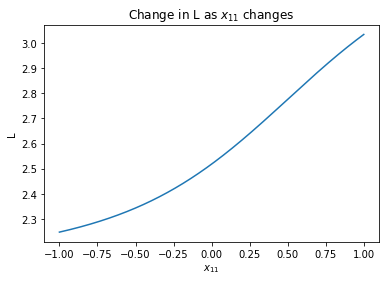

In [133]:
plt.plot(x11s, Ls)
plt.title("Change in L as $x_{11}$ changes")
plt.xlabel("$x_{11}$")
plt.ylabel("L")
plt.savefig("21_L_vs_x11.png")

In [18]:
W = torch.empty(2, 2).uniform_(-1, 1)
B = torch.randn((2,2))

In [15]:
def matrix_sum_forward(w: Tensor, 
                       b: Tensor, 
                       sigma: Tensor_Function) -> float:
    '''
    TODO
    '''    
    assert w.shape == b.shape
    
    # matrix multiplication
    A = torch.add(w, b)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(A)
    
    # sum all the elements
    L = torch.sum(S)
    
    return L

In [16]:
def matrix_sum_backward(w: Tensor, 
                        b: Tensor, 
                        sigma: Tensor_Function) -> float:
    '''
    TODO
    '''    
    assert w.shape == b.shape
    
    # matrix multiplication
    A = torch.add(w, b)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(A)
    
    # sum all the elements
    L = torch.sum(S)
    
    dLdS = torch.ones_like(S)
    
    dSdA = deriv(sigma, A)
    
    dLdA = dLdS * dSdA
    
    dAdW = torch.ones_like(A)
    
    dLdW = dLdA * dAdW
    
    return dLdW

In [19]:
matrix_sum_forward(W, B, sigmoid)

tensor(2.3585)

In [20]:
matrix_sum_backward(W, B, sigmoid)

tensor([[0.2121, 0.2049],
        [0.1670, 0.1926]])

TODO: Plot L as a function of $x_{11}$

### Basic function definitions

In [3]:
# y = x^2
from typing import Callable

Tensor_Function = Callable[[Tensor], Tensor]

def deriv(func: Tensor_Function, 
          input: Tensor, 
          diff: float = 0.001) -> Tensor:
    '''
    Evaluates the derivative of a function f at every element in the Tensor.
    '''
    return (func(input + diff) - func(input - diff)) / (2 * diff)

In [4]:
def relu(x: Tensor) -> Tensor:
    '''
    Apply "ReLU" function to Tensor
    '''
    return torch.clamp(x, min=0)

In [5]:
a = Tensor([[1, 2], 
           [3, 4]])

def square(x: Tensor) -> Tensor:
    '''
    Square each element in the input Tensor.
    '''
    return x.pow(2)

deriv(square, a)

tensor([[ 2.0000,  3.9999],
        [ 5.9996,  7.9999]])

## Matrix multiplication

In [10]:
def tensor_size(tensor: Tensor) -> int:
    '''
    Returns the number of elements in a 1D Tensor
    '''
    assert tensor.dim() == 1, \
    "Input tensors must be 1 dimensional"
    
    return list(tensor.size())[0]

In [11]:
def to_2d(a: Tensor, 
          type: str="col") -> Tensor:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.dim() == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(tensor_size(a), 1)
    elif type == "row":
        return a.reshape(1, tensor_size(a))

In [16]:
X = Tensor([1,2,3])
W = Tensor([0.1,0.2,0.3])

B = Tensor([4])

X = to_2d(X, "row")
W = to_2d(W, "col")

In [18]:
(torch.mm(X, W) + B).item()

5.400000095367432

In [19]:
4.0 * W.transpose(0, 1)

tensor([[ 0.4000,  0.8000,  1.2000]])

### First plot

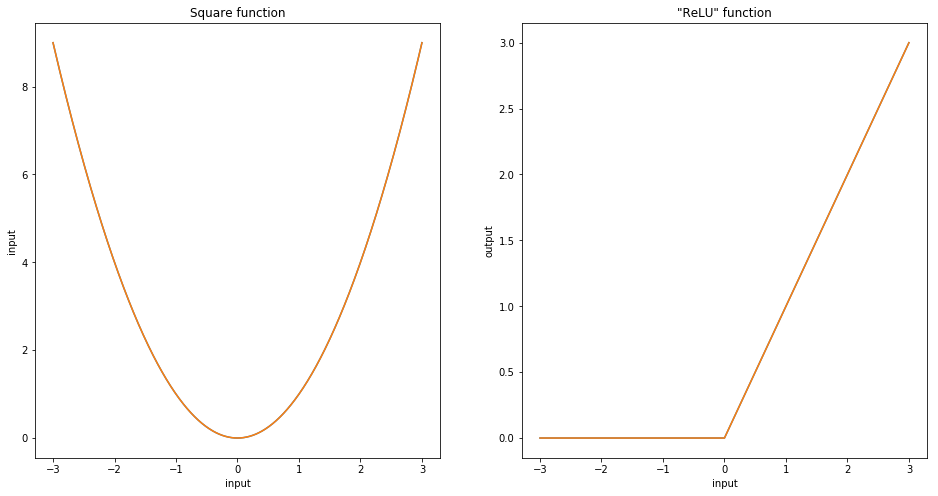

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # 2 Rows, 1 Col

input_range = torch.range(-3, 3, 0.01)

ax[0].plot(input_range.numpy(), square(input_range).numpy())
ax[0].plot(input_range.numpy(), square(input_range).numpy())
ax[0].set_title('Square function')
ax[0].set_xlabel('input')
ax[0].set_ylabel('input')

ax[1].plot(input_range.numpy(), relu(input_range).numpy())
ax[1].plot(input_range.numpy(), relu(input_range).numpy())
ax[1].set_title('"ReLU" function')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output');

# plt.savefig("../images/01_foundations/00_x_vs_x_squared.png")

### Decorators

In [27]:
class deriv_dec(object):

    def __init__(self, f: Tensor):
        self.f = f

    def __call__(self, input: Tensor,
                 diff: float = 0.001):
        '''
        Evaluates the derivative of a function f at every element in the Tensor.
        '''
        return (self.f(input + diff) - self.f(input - diff)) / (2 * diff)

In [28]:
class plot_function_range_dec(object):

    def __init__(self, f):
        self.f = f

    def __call__(self, input_range):
        output_range = self.f(input_range)
        plt.plot(input_range.numpy(), output_range.numpy());

Text(0.5,1,'Derivatives of x squared and ReLU')

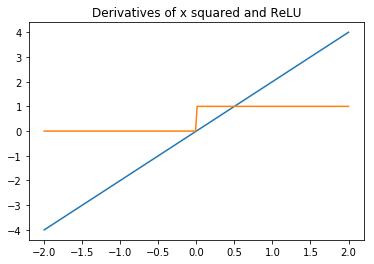

In [29]:
@plot_function_range_dec
@deriv_dec
def square(x: Tensor) -> Tensor:
    '''
    Square each element in the input Tensor.
    '''
    return x ** 2

@plot_function_range_dec
@deriv_dec
def relu(x: Tensor) -> Tensor:
    '''
    Apply "ReLU" function to Tensor
    '''
    return torch.clamp(x, min=0)

square(torch.range(-2, 2, 0.01))
relu(torch.range(-2, 2, 0.01))
plt.title("Derivatives of x squared and ReLU")
# plt.savefig(IMAGE_FOLDER + "09_derivatives_range.png")

### Function definition

$$ f(E) = P $$ 

is equivalent to 

```python
def f(input_tensor: Tensor) -> Tensor:
    # Some transformation(s)
    return output_tensor

P = f(E)
```

### Chain rule

In [30]:
def square(x: Tensor) -> Tensor:
    '''
    Square each element in the input Tensor.
    '''
    return x.pow(2)

def sigmoid(x: Tensor) -> Tensor:
    '''
    Square each element in the input Tensor.
    '''
    return 1 / (1 + torch.exp(-x))

In [36]:
# y = x^2
from typing import List

Function = Callable[[Tensor], Tensor]
Chain = List[Function]

def chain_length_2(chain: Chain,
                   t: Tensor) -> Tensor:
    '''
    Evaluates two functions in a row, in a "Chain".
    '''
    assert len(chain) == 2, \
    "Length of input Chain should be 2"
    
    f1 = chain[0]
    f2 = chain[1]
    
    return f2(f1(t))

In [37]:
def chain_deriv_2(chain: Chain,
                  input_range: Tensor) -> Tensor:
    '''
    Uses the chain rule to compute the derivative of two nested functions:

    '''

    assert len(chain) == 2, \
    "This function requires 'Chain' objects of length 2"

    assert input_range.dim() == 1, \
    "Function requires a 1 dimensional Tensor as input_range"

    f1 = chain[0]
    f2 = chain[1]

    # f1(x)
    f1_of_x = f1(input_range)

    # f1'(x)
    f1_prime = deriv(f1, input_range)

    # f2'(f1(x))
    f2_prime = deriv(f2, f1(input_range))

    # Multiplying these quantities together at each point
    return f1_prime.mul(f2_prime)

### Chain rule

In [38]:
def plot_chain(chain: Chain, 
                     input_range: Tensor) -> None:
    '''
    Plots a chain function - a function made up of 
    multiple consecutive Tensor -> Tensor mappings - across one
    '''
    
    assert input_range.dim() == 1, \
    "message"
    output_range = chain_length_2(chain, input_range)
    plt.plot(input_range.numpy(), output_range.numpy())

In [39]:
def plot_chain_deriv(chain: Chain,
                     input_range: Tensor) -> Tensor:
    '''
    Uses the chain rule to plot the derivative of two nested functions:
    '''
    output_range = chain_deriv_2(chain, input_range)
    plt.plot(input_range.numpy(), output_range.numpy())

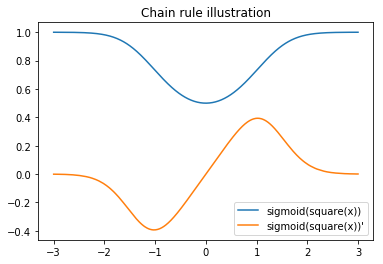

In [41]:
PLOT_RANGE = torch.range(-3, 3, 0.01)
plot_chain([square, sigmoid], PLOT_RANGE)
plot_chain_deriv([square, sigmoid], PLOT_RANGE)
plt.title("Chain rule illustration")
plt.legend(["sigmoid(square(x))", "sigmoid(square(x))'"])
# plt.savefig(IMAGE_FOLDER + "15.1_chain_rule_illustration_1.png");

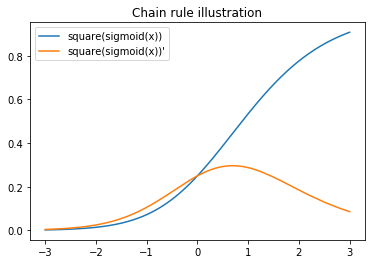

In [42]:
plot_chain([sigmoid, square], torch.range(-3, 3, 0.01))
plot_chain_deriv([sigmoid, square], torch.range(-3, 3, 0.01))
plt.title("Chain rule illustration")
plt.legend(["square(sigmoid(x))", "square(sigmoid(x))'"])
# plt.savefig(IMAGE_FOLDER + "15.2_chain_rule_illustration_2.png");

### Chain rule: three functions

In [43]:
def leaky_relu(x: Tensor) -> Tensor:
    '''
    Apply "ReLU" function to Tensor
    '''
    return torch.max(0.2 * x, x)

In [47]:
def chain_length_3(chain: Chain,
                   input_range: Tensor) -> Tensor:
    '''
    Uses the chain rule to compute the derivative of two nested functions:
    '''
    
    assert len(chain) == 3
    
    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]
    
    # f1'(x)
    f1_of_x = f1(input_range)
    
    # f2(f1(x))
    f2_of_x = f2(f1_of_x)
    
    return f3(f2_of_x)

In [48]:
def chain_deriv_3(chain: Chain,
                  input_range: Tensor) -> Tensor:
    '''
    Uses the chain rule to compute the derivative of two nested functions:
    '''
    
    assert len(chain) == 3
    
    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]
    
    # f1'(x)
    f1_of_x = f1(input_range)
    
    # f2(f1(x))
    f2_of_x = f2(f1_of_x)
    
    # f3'f2(f1(x))
    f3_prime = deriv(f3, f2_of_x)
    
    # f2'(f1(x))
    f2_prime = deriv(f2, f1_of_x)
    
    # f1'(x)
    f1_prime = deriv(f1, input_range)
    
    # Multiplying these quantities together at each point
    return torch.mul(torch.mul(f3_prime, f2_prime), f1_prime)

In [51]:
def plot_chain(chain: Chain, 
                     input_range: Tensor) -> None:
    '''
    Plots a chain function - a function made up of 
    multiple consecutive Tensor -> Tensor mappings - across one
    '''
    
    assert input_range.dim() == 1, \
    "message"
    output_range = chain_length_3(chain, input_range)
    plt.plot(input_range.numpy(), output_range.numpy())

In [52]:
def plot_chain_deriv(chain: Chain,
                     input_range: Tensor) -> Tensor:
    '''
    Uses the chain rule to plot the derivative of two nested functions:
    '''
    output_range = chain_deriv_3(chain, input_range)
    plt.plot(input_range.numpy(), output_range.numpy())

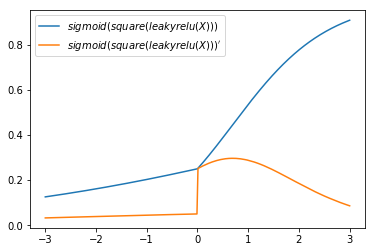

In [53]:
plot_chain([leaky_relu, sigmoid, square], PLOT_RANGE)
plot_chain_deriv([leaky_relu, sigmoid, square], PLOT_RANGE)
plt.legend(["$sigmoid(square(leakyrelu(X)))$", "$sigmoid(square(leakyrelu(X)))'$"])
# plt.savefig(IMAGE_FOLDER + "11_plot_function_derivative_1.png")

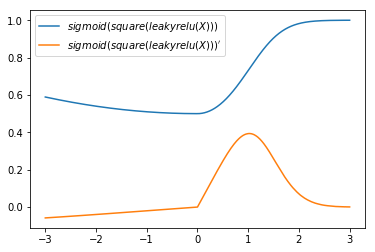

In [55]:
plot_chain([leaky_relu, square, sigmoid], PLOT_RANGE)
plot_chain_deriv([leaky_relu, square, sigmoid], PLOT_RANGE)
plt.legend(["$sigmoid(square(leakyrelu(X)))$", "$sigmoid(square(leakyrelu(X)))'$"])
# plt.savefig(IMAGE_FOLDER + "11_plot_function_derivative_2.png")

### Cross product multiply

In [56]:
def tensor_size(tensor: Tensor) -> int:
    '''
    Returns the number of elements in a 1D Tensor
    '''
    assert tensor.dim() == 1, \
    "Input tensors must be 1 dimensional"
    
    return list(tensor.size())[0]

In [57]:
def to_2d(a: Tensor, 
          type: str="col") -> Tensor:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.dim() == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(tensor_size(a), 1)
    elif type == "row":
        return a.reshape(1, tensor_size(a))

In [58]:
def cross_product_multiply(t1: Tensor, 
                           t2: Tensor) -> Tensor:
    '''
    Cross product multiply of two 1D Tensors
    '''
    
    assert t1.dim() == 1, \
    "Input tensors must be 1 dimensional"
    assert t2.dim() == 1, \
    "Input tensors must be 1 dimensional"
    
    t1 = to_2d(t1, "row")
    t2 = to_2d(t2, "col")
    
    return t1.mul(t2)

### Simple forward and simple backward

In [59]:
def simple_forward(sigma: Function,
                   X: Tensor,
                   Y: Tensor) -> Tensor:
    '''

    '''

    m = cross_product_multiply(X, Y)

    return sigma(m)

In [71]:
def simple_backward(sigma: Function,
                    X: Tensor,
                    Y: Tensor) -> Dict[str, Tensor]:
    '''
    Compute the derivative of f with respect to X
    '''

    c = cross_product_multiply(X, Y)

    sigma_prime_y = deriv(sigma, c)

    # Note: to_2d is a helper function that transforms 1D arrays into 2D vectors
    Y_2d = to_2d(Y)
    import pdb; pdb.set_trace()
    return Y_2d.mul(sigma_prime_y)

### Take slices and plot result

In [72]:
def plot_two_ranges(range1: Tensor, 
                    range2: Tensor) -> None:

    assert range1.dim() == 1
    assert range2.dim() == 1
    
    plt.plot(range1.numpy(), range2.numpy())

In [73]:
X = torch.range(-2, 0, 0.01)
Y = torch.range(0, 2, 0.01)

forward = simple_forward(sigmoid, X, Y)

import random
random.seed(51618)
r = random.randint(1, 201)

backward = simple_backward(sigmoid, X, Y)

plot_two_ranges(X, forward[r])
plot_two_ranges(X, backward[r])
plt.legend(["Original function", "Derivative"])
# plt.savefig(IMAGE_FOLDER + "12_simple_function_derivative.png")

> <ipython-input-71-f798c5f85d94>(15)simple_backward()
-> return Y_2d.mul(sigma_prime_y)
(Pdb) Y_2d
tensor([[ 0.0000],
        [ 0.0100],
        [ 0.0200],
        [ 0.0300],
        [ 0.0400],
        [ 0.0500],
        [ 0.0600],
        [ 0.0700],
        [ 0.0800],
        [ 0.0900],
        [ 0.1000],
        [ 0.1100],
        [ 0.1200],
        [ 0.1300],
        [ 0.1400],
        [ 0.1500],
        [ 0.1600],
        [ 0.1700],
        [ 0.1800],
        [ 0.1900],
        [ 0.2000],
        [ 0.2100],
        [ 0.2200],
        [ 0.2300],
        [ 0.2400],
        [ 0.2500],
        [ 0.2600],
        [ 0.2700],
        [ 0.2800],
        [ 0.2900],
        [ 0.3000],
        [ 0.3100],
        [ 0.3200],
        [ 0.3300],
        [ 0.3400],
        [ 0.3500],
        [ 0.3600],
        [ 0.3700],
        [ 0.3800],
        [ 0.3900],
        [ 0.4000],
        [ 0.4100],
        [ 0.4200],
        [ 0.4300],
        [ 0.4400],
        [ 0.4500],
        [ 0.4600],
       

BdbQuit: 

In [66]:
X.shape

torch.Size([201])

In [67]:
Y.shape

torch.Size([201])

In [65]:
backward.shape

torch.Size([201, 201])

In [ ]:
simple_backward

In [81]:
a = Tensor([1,2])
b = Tensor([[3,4], 
            [5,6]])

In [82]:
a2 = to_2d(a)
a2.shape

torch.Size([2, 1])

In [83]:
a2.mul(b)

tensor([[  3.,   4.],
        [ 10.,  12.]])

### Complex function

In [40]:
def cross_product_add(t1: Tensor, 
                      t2: Tensor) -> Tensor:
    '''
    Cross product multiply of two 1D Tensors
    '''
    
    assert t1.dim() == 1, \
    "Input tensors must be 1 dimensional"
    assert t2.dim() == 1, \
    "Input tensors must be 1 dimensional"
    
    t1 = to_2d(t1, "row")
    t2 = to_2d(t2, "col")
    
    return t1.add(t2)

In [48]:
a = Tensor([1, 2])
b = Tensor([3, 4])
cross_product_add(a, b)

tensor([[ 4.,  5.],
        [ 5.,  6.]])

In [65]:
def complex_forward(e: Function,
                    f: Function,
                    g: Function,
                    h: Function,
                    j: Function,
                    k: Function,
                    X: Tensor,
                    Y: Tensor) -> Dict[str, Tensor]:
    '''
    Uses the chain rule to compute the derivative of two nested functions:
    '''

    e_output = e(X)

    f_output = f(e_output)

    g_output = g(Y)

    h_output = h(g_output)

    I = cross_product_add(f_output, h_output)

    forward_info: Dict[str, Tensor] = {}
    forward_info['E'] = e_output
    forward_info['F'] = f_output
    forward_info['G'] = g_output
    forward_info['H'] = h_output
    forward_info['I'] = I
    forward_info['J'] = j(I)
    forward_info['K'] = k(I)

    return forward_info

In [66]:
def square(x: Tensor) -> Tensor:
    '''
    Square each element in the input Tensor.
    '''
    return torch.pow(x, 2)

def relu(x: Tensor) -> Tensor:
    '''
    Apply "ReLU" function to Tensor
    '''
    return torch.clamp(x, min=0)

def sqrt(x: Tensor) -> Tensor:
    '''
    Square root of each element in the input Tensor.
    '''
    return torch.sqrt(x+1)

def poly(x: Tensor) -> Tensor:
    '''
    Square each element in the input Tensor.
    '''
    return x ** 3 + x + 1

In [67]:
def deriv_k_wrt_y(e: Function,
                  f: Function,
                  g: Function,
                  h: Function,
                  j: Function,
                  k: Function,
                  X: Tensor,
                  Y: Tensor) -> Tensor:
    '''
    Uses the chain rule to compute the derivative of two nested functions:
    '''

    assert X.shape == Y.shape, \
    "Input ranges must be the same shape"

    forward_info = complex_forward(e, f, g, h, j, k, X, Y)

    k_prime_i = deriv(k, forward_info['I'])
    
    # Applying the fact that, if i(f, h) = f + h, di/dh = 1
    i_prime_h = torch.ones_like(k_prime_i)
    k_prime_h = k_prime_i * i_prime_h

    # Using the matrix factorization trick to compute dk/dg = dk/dh * dh/dg
    h_prime_g = to_2d(deriv(h, forward_info['G']))
    k_prime_g = h_prime_g.mul(k_prime_h)

    # Using the matrix factorization trick to compute dk/dy = dk/dg * dg/dy    
    g_prime_y = to_2d(deriv(g, Y))
    k_prime_y = g_prime_y.mul(k_prime_g)

    return k_prime_y

### Plotting complex results

In [68]:
import random
random.seed(52218)
r = random.randint(1, 201)

In [69]:
x_range = torch.range(-2, 0, 0.01)
y_range = torch.range(0, 2, 0.01)

forward_info = complex_forward(poly, sigmoid, square, relu, sqrt, sigmoid,
                               x_range, 
                               y_range)
forward = forward_info['K'][:, r]

backward_info = deriv_k_wrt_y(poly, sigmoid, square, relu, sqrt, sigmoid,
                              x_range, 
                              y_range)

backward = backward_info[:, r]

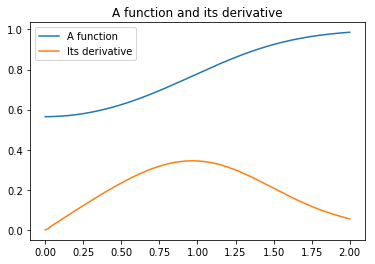

In [70]:
plot_two_ranges(y_range, forward)
plot_two_ranges(y_range, backward)
plt.title("A function and its derivative")
plt.legend(["A function", "Its derivative"])
plt.savefig(IMAGE_FOLDER + "14_a_function_and_its_derivative.png");